# Feature Extraction 

In [242]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Image, display

## Load and Pre-Process Audio 

I am using a sample here, but this is where the user input will go


In [266]:
audio_path = 'royalty-free-music/bensound-dubstep.mp3'

In [268]:
ipd.Audio(audio_path)

In [270]:
#y = an audio time series, visualized by a waveform (np array)  
#sr = sample rate, default = 22KHz (int)

y, sr = librosa.load('royalty-free-music/bensound-dubstep.mp3',sr=None, duration= 30)
# sr= None:loads audio signals at their original sample rate
# duration = 30: takes 30 seconds of the audio (for testing effciency)

In [272]:
print(y.size, sr)
# y.size is the number of samples

1323000 44100


**Beat frames and Beat times are going to be used to map the time of appearance/disappearance of shapes**

In [275]:
#tempo = beats per minute (np array,single element)
#beat_frame = array of frame numbers corresponding to detected beat events (np,array)

tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

In [277]:
# beat_times = timestamps of beat frames
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

In [279]:
beat_frames, beat_times

(array([ 572,  643,  715,  786,  857,  927,  999, 1071, 1142, 1214, 1283,
        1356, 1427, 1498, 1570, 1642, 1712, 1784, 1855, 1926, 1998, 2069,
        2140, 2212, 2283, 2354, 2425, 2496, 2567]),
 array([ 6.64090703,  7.46521542,  8.30113379,  9.12544218,  9.94975057,
        10.76244898, 11.59836735, 12.43428571, 13.2585941 , 14.09451247,
        14.89560091, 15.74312925, 16.56743764, 17.39174603, 18.2276644 ,
        19.06358277, 19.87628118, 20.71219955, 21.53650794, 22.36081633,
        23.19673469, 24.02104308, 24.84535147, 25.68126984, 26.50557823,
        27.32988662, 28.15419501, 28.9785034 , 29.80281179]))

In [281]:
#pre-define frame size and hop length so it stays constant throughout 
FRAME_LENGTH = 2048
HOP_LENGTH = 512

## Pitch

- measured in frequency (Hz)
- **convert fundamental frequency (f0) to midi note number so that they could be mapped onto corresponding colors**
- each note within an octave will have different hues
- each succeeding octave will have progressing brightness

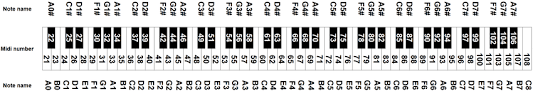

In [285]:
display(Image(filename='midinotes.png', width=1000))

In [287]:
#using librosa.pyin to extract the f0, staring from mininote A0 to C8
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             sr=sr,
                                             frame_length = FRAME_LENGTH,
                                             hop_length = HOP_LENGTH,
                                             fmin=librosa.note_to_hz('A0'),
                                             fmax=librosa.note_to_hz('C8'))

f0 = np.nan_to_num(f0, nan=np.nanmean(f0))  
#if there are NaN values, replace them with the mean pitch

frames_f0 = range(len(f0))
times_f0 = librosa.frames_to_time(frames_f0,sr=sr)
#frames_to_time: convert an array of frame indices to timestamps
#here it gives the corresponding time value of each pitch frame

midi = librosa.hz_to_midi(f0)
#convert frequency to midi note number

/var/folders/9z/nkmcz1q52w51gyzhl1bbdqt40000gn/T/ipykernel_73472/4032194849.py:2: UserWarning: With fmin=27.500, sr=44100 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=43.066 or frame_length=3209.
  f0, voiced_flag, voiced_probs = librosa.pyin(y,


Text(0.5, 0, 'Time (s)')

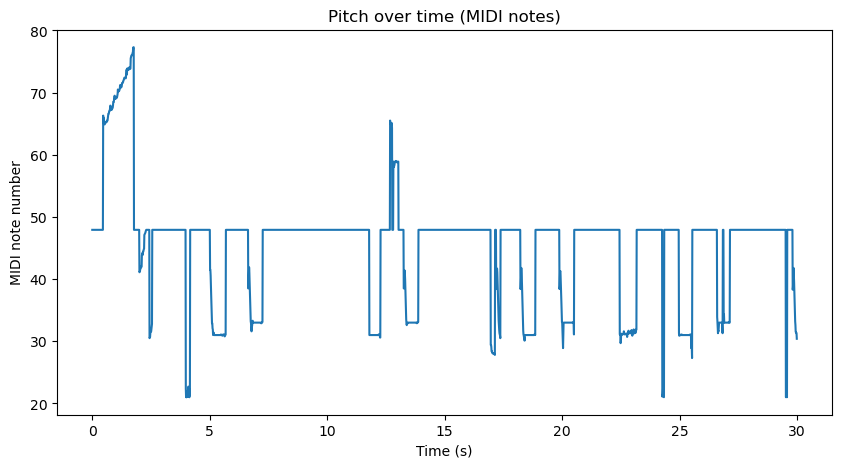

In [350]:
#plot freqency as midinotes 
plt.figure(figsize=(10, 5))
plt.plot(times_f0, midi)
# x axis: time (trimmed to the same length as the number of midi values)
# y axis: midi values
plt.title("Pitch over time (MIDI notes)")
plt.ylabel("MIDI note number")
plt.xlabel("Time (s)")

## Loudness

- Subjective measure of sound intensity (sound power per unit area (W/m^2))
- digitalized using Root-mean-square energy (Rms) of all samples in frame
    * time-domain feature
- Less sensitive to outliers than amplitude envelop (creates smoother visuals)
- **maps to the size of the shape representing each sound**

In [381]:
#extract rms
rms = librosa.feature.rms(y=y,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

frames_rms = range(len(rms))
times_rms = librosa.frames_to_time(frames_rms,sr=sr, hop_length=HOP_LENGTH)

Text(75.97222222222221, 0.5, 'RMS energy')

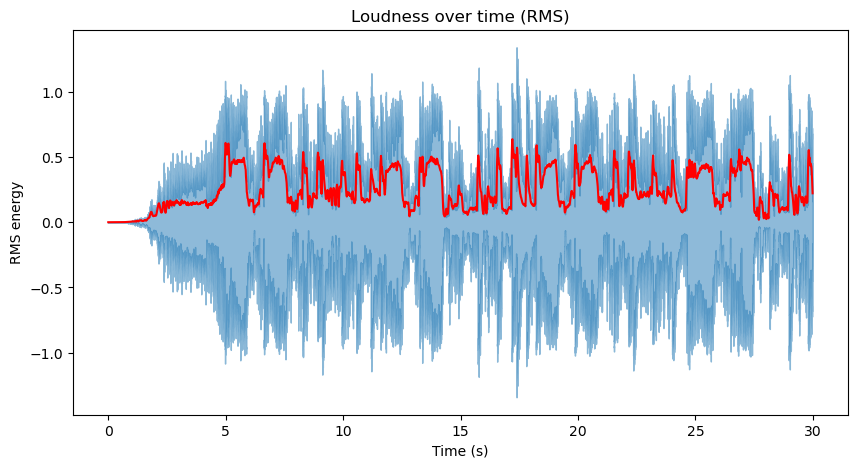

In [383]:
#plot RMS on the waveform
plt.figure(figsize=(10, 5))
librosa.display.waveshow(y,sr=sr,alpha=0.5)
plt.plot(times_rms,rms, color="r")
plt.title("Loudness over time (RMS)")
plt.xlabel("Time (s)")
plt.ylabel("RMS energy")

## Timbre

- tone quality
- difference between two sounds with the same frequency, intensity, duration
- **use Mel-frequency cepstral coefficent to map to the shape of the sound**
    * each coefficent of MFCC describes progressively finer detail of the sound’s spectral shape 

In [377]:
mfccs = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
# n_mfcc = the number of coefficients, 13 is the typical amount to extract for musical analysis and speech recognition

frames_mfccs = range(mfccs.shape[1])  #the number of time frames corresponds to columns
times_mfccs = librosa.frames_to_time(frames_mfccs, sr=sr, hop_length=HOP_LENGTH)

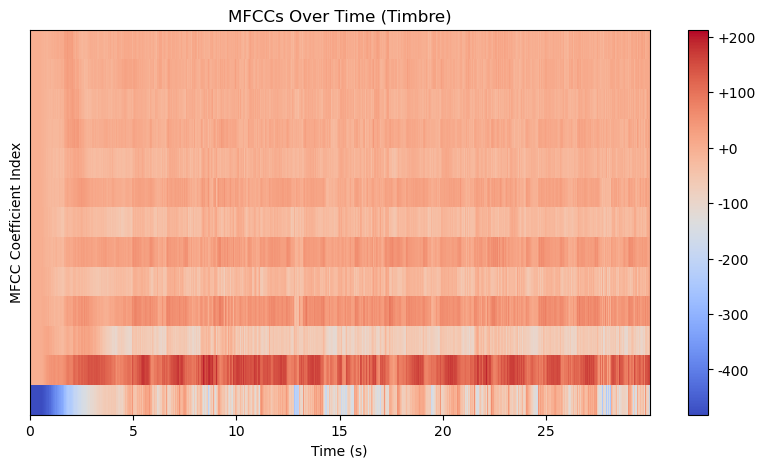

In [379]:
# plot MCSS
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.title("MFCCs Over Time (Timbre)")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficient Index")
plt.show()

## Consolidate into Functions

In [395]:
def extract_audio_features(audio_path: str, duration: float = None, HOP_LENGTH: int = 512, FRAME_LENGTH: int = 2048 ):
    """
    This function loads an audio file and extracts audio features: pitch (f0), loudness (RMS energy), and timbre (MFCC) for each beat frame.
    It also normalizes those features on a 0-1 scale for visual mapping.
    
    Parameters:
        audio_path: str
            path to any audio file format (.wav, .mp3, .ogg, etc.)
        duration: float, optional
            Duration from the start of the file (seconds). 
            Loads the full track if none. 
        hop_length: int, fixed
            Number of samples between frames.
        frame_length: int, fixed
            Number of samples per frame. 

    Returns:
         audio_features : dict
            times: array of frame timestamps,
            midi: normalized midi number ,
            rms: normalized loudness,
            mfcc: normalized MFCC matrix
    """

    # Load audio file
    y, sr = librosa.load(audio_path, duration=duration)

    # 1. Pitch (f0) extraction
    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             sr=sr,
                                             frame_length = FRAME_LENGTH,
                                             hop_length = HOP_LENGTH,
                                             fmin=librosa.note_to_hz('A0'),
                                             fmax=librosa.note_to_hz('C8'))
    f0 = np.nan_to_num(f0, nan=np.nanmean(f0))  
    #if there are NaN values, replace them with the mean pitch
    midi = librosa.hz_to_midi(f0)
    #convert frequency to midi note number

    # 2. Loudness(RMS energy) extraction
    rms = librosa.feature.rms(y=y,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    
    # 3. Timbre (MFCC) extraction
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

    # Time stamps for mapping to pygame 
    times = librosa.times_like(rms, sr=sr, hop_length=HOP_LENGTH)

    # Normalize numerical features for mapping (0–1 range)
    def normalize(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    midi_norm = normalize(midi)
    rms_norm = normalize(rms)
    mfcc_norm = np.apply_along_axis(normalize, 1, mfcc)
    
    audio_features = {
        "times" : times,
        "midi" : midi_norm,
        "rms" : rms_norm,
        "mfcc" : mfcc_norm
    }
    
    return audio_features

In [401]:
extract_audio_features(audio_path)

{'times': array([0.00000000e+00, 2.32199546e-02, 4.64399093e-02, ...,
        1.24830476e+02, 1.24853696e+02, 1.24876916e+02]),
 'midi': array([0.27966346, 0.27966346, 0.27966346, ..., 0.27966346, 0.27966346,
        0.27966346]),
 'rms': array([0.0000000e+00, 4.4918456e-06, 8.0694990e-06, ..., 1.6179568e-03,
        1.5608657e-03, 1.3259886e-03], dtype=float32),
 'mfcc': array([[0.        , 0.        , 0.        , ..., 0.00260237, 0.00258516,
         0.00363943],
        [0.18861897, 0.18861897, 0.18861897, ..., 0.19762541, 0.19756569,
         0.20121199],
        [0.59395033, 0.59395033, 0.59395033, ..., 0.608886  , 0.608787  ,
         0.61482215],
        ...,
        [0.5207492 , 0.5207492 , 0.5207492 , ..., 0.54645914, 0.54628867,
         0.5560446 ],
        [0.5117609 , 0.5117609 , 0.5117609 , ..., 0.53671294, 0.5365475 ,
         0.5458833 ],
        [0.55261743, 0.55261743, 0.55261743, ..., 0.5844904 , 0.5842791 ,
         0.59602004]], dtype=float32)}